In [ ]:
import math 
import yfinance as yf
import numpy as np
import pandas as pd #read write Dataframe
from sklearn.preprocessing import MinMaxScaler # scale data between 0 and 1 ; sklearn = scikit learn
import matplotlib.pyplot as plt #graph plot
import tensorflow as tf # Deep learning functions
from tensorflow import keras # nweural network functions
from tensorflow.keras import layers # Neural netwwork layers

stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data.head() # first 5 rows of dataset

Text(0, 0.5, 'Prices ($)')

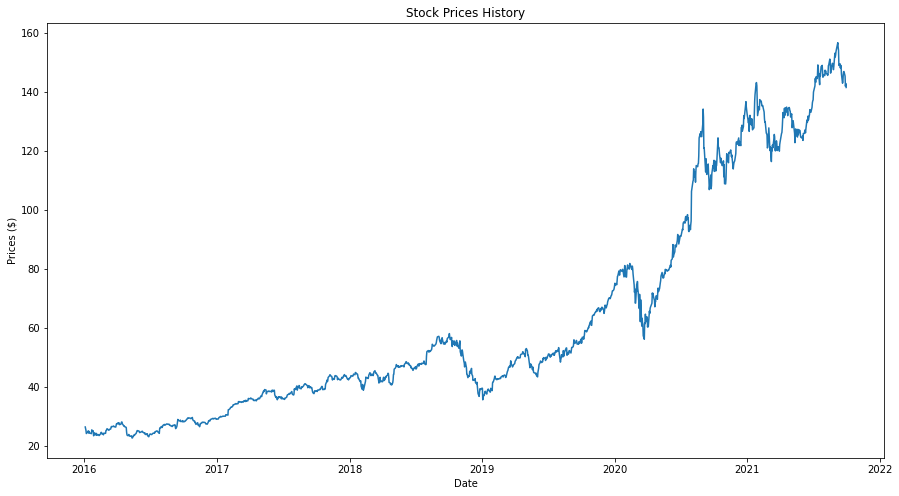

In [ ]:
plt.figure(figsize=(15, 8)) # make empty plot
plt.title('Stock Prices History') # set title
plt.plot(stock_data['Close']) # create plot
plt.xlabel('Date') # set label on X axis
plt.ylabel('Prices ($)')

## Training data

In [ ]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8) # 80% training data

scaler = MinMaxScaler(feature_range=(0,1)) # create scaler object
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = [] # features (questions)
y_train = [] # labels (answers)

for i in range(60, len(train_data)): # last 60 days
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Testing data

In [ ]:
test_data = scaled_data[training_data_len-60: , : ] 
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Creating model

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error') # adjust wt and bias
model.fit(x_train, y_train, batch_size= 1, epochs=3) # start training

Epoch 1/3
1098/1098 [==============================] - 40s 33ms/step - loss: 7.8324e-04
Epoch 2/3
1098/1098 [==============================] - 37s 34ms/step - loss: 3.1332e-04
Epoch 3/3
1098/1098 [==============================] - 36s 33ms/step - loss: 2.7094e-04


In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # denormalize
rmse = np.sqrt(np.mean(predictions - y_test)**2) # root mean square error
rmse

4.207573755389679

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


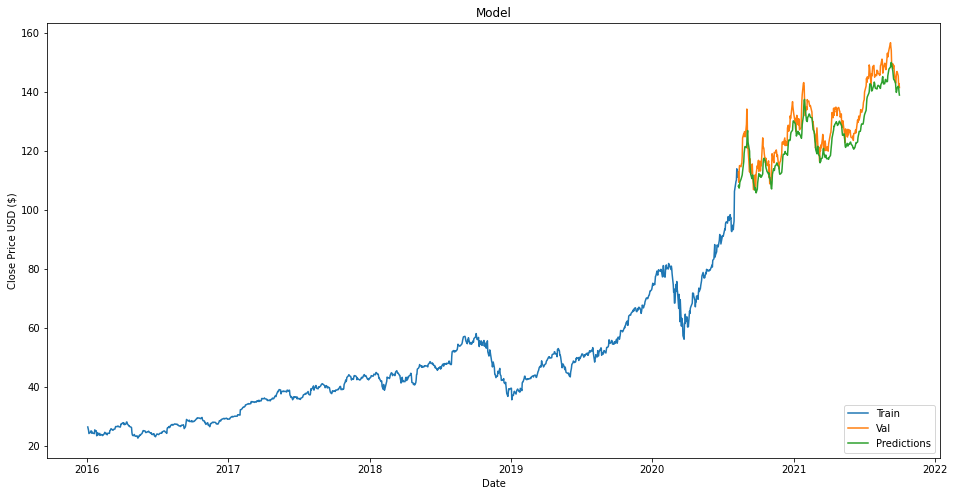

In [ ]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()